# S&P500 price prediction - Time series forecasting

## 1. Preprocessing data

In [220]:
import yfinance as yf

In [221]:
import pandas as pd

In [222]:
sp500 = yf.Ticker('^GSPC')

In [223]:
sp500 = sp500.history(period="max")

In [224]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-07-13 00:00:00-04:00,4491.500000,4517.379883,4489.359863,4510.040039,3839530000,0.0,0.0
2023-07-14 00:00:00-04:00,4514.609863,4527.759766,4499.560059,4505.419922,3647450000,0.0,0.0
2023-07-17 00:00:00-04:00,4508.859863,4532.850098,4504.899902,4522.790039,3538240000,0.0,0.0


In [225]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2023-07-06 00:00:00-04:00', '2023-07-07 00:00:00-04:00',
               '2023-07-10 00:00:00-04:00', '2023-07-11 00:00:00-04:00',
               '2023-07-12 00:00:00-04:00', '2023-07-13 00:00:00-04:00',
               '2023-07-14 00:00:00-04:00', '2023-07-17 00:00:00-04:00',
               '2023-07-18 00:00:00-04:00', '2023-07-19 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24001, freq=None)

<AxesSubplot: title={'center': 'S&P500 close price from 1940 to 2020'}, xlabel='Date'>

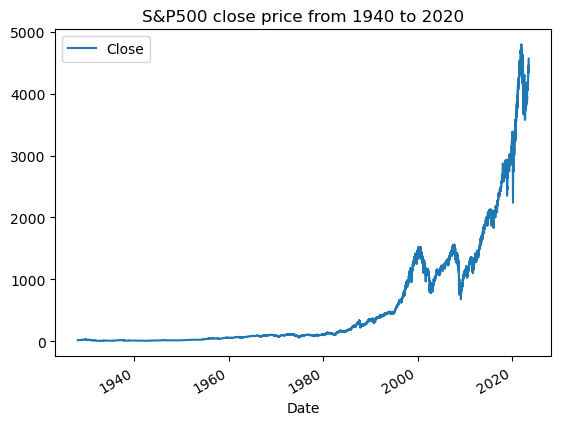

In [226]:
sp500.plot.line(y="Close", use_index=True, title="S&P500 close price from 1940 to 2020")

In [227]:
del sp500['Dividends']
del sp500['Stock Splits']

Not predict absolute price of tomorrow price. When buying or selling stock, just care about direction of stock price like whether the stock go up or down. 

In [228]:
sp500['Tomorrow'] = sp500['Close'].shift(-1)

When Tomorrow price > Today price (close price) means stock price would go up:
    Target = 1

And when Target = 0 means stock price would go down.

In [229]:
sp500['Target'] = (sp500['Tomorrow']>sp500['Close']).astype(int)

Remove too old data which is not used in prediction.

In [230]:
#only get data from 1990 till now
sp500 = sp500.loc['1990-01-01':].copy()

## 2. Choosing model

### Random Forest Classifier (RFC)
Why choosing RFC model for this datapoint?
- Stock price is time series data.
- Features are numerical.
- Prediction feature is "Target": whether the stock price would go up or down? (1 or 0).
- Predict stock price is a binary classification problem.
- Random Forest (RF) performs well with larger datasets such as capable of capturing even non-linear relationships. In this case, the Open price does not related to Target.
- Also, because RF train various individual decision trees with randomize parameters and averaging the result from those decision trees, RF are resisting to overfitting.

In [231]:
from sklearn.ensemble import RandomForestClassifier

In [232]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

not use cross validation split the data because it does not take time series nature into acct. Result in leakage. 

In [233]:
train = sp500[:-100]
test = sp500[-100:]

In [234]:
predictors = ['Close', 'Volume','Open', 'High', 'Low']
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [235]:
from sklearn.metrics import precision_score

measure how accurate the model is:
precision score: when we said the market would go up (target is 1), did it actually go up?
 

In [236]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [237]:
precision_score(test['Target'], preds)

0.6382978723404256

As 0.63 is low precision score, we need to improve the accuracy of model. Let's plot this model to see how it works.

In [238]:
combined = pd.concat([test['Target'], preds], axis=1)

<AxesSubplot: title={'center': 'How model works compared to actual data'}, xlabel='Date'>

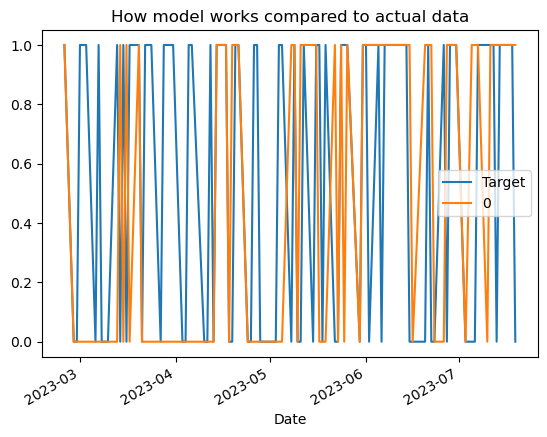

In [239]:
combined.plot(title="How model works compared to actual data")

In [240]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [241]:
#back testing
def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = [] #list for each df is a single year

    for i in range(start, data.shape[0], step): #loop across data year by year & make prediction for all the year except first 10 years 
        train = data.iloc[0:i].copy() #all the years prior to current year
        test = data.iloc [i:(i+step)].copy() #current year
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [242]:
predictions = backtest (sp500, model, predictors)

[Text(0, 0, '3433'), Text(0, 0, '2518')]

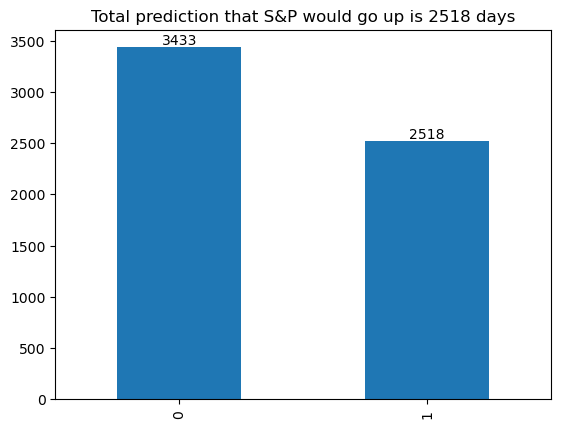

In [243]:
ax1=predictions['Predictions'].value_counts().plot.bar(title='Total prediction that S&P would go up is 2518 days')
ax1.bar_label(ax1.containers[0])

We predict the market would go up for 3433 days and go down for 2518 days.

In [244]:
precision_score_old=precision_score(predictions['Target'], predictions["Predictions"])

To see whether the precision_score = 0.53 is good enough, we have to look at percentage of the day the market actually went up.

In [245]:
predictions['Target'].value_counts()/predictions.shape[0]

1    0.534196
0    0.465804
Name: Target, dtype: float64

In [246]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-07-13 00:00:00-04:00,4491.500000,4517.379883,4489.359863,4510.040039,3839530000,4505.419922,0
2023-07-14 00:00:00-04:00,4514.609863,4527.759766,4499.560059,4505.419922,3647450000,4522.790039,1
2023-07-17 00:00:00-04:00,4508.859863,4532.850098,4504.899902,4522.790039,3538240000,4554.979980,1


## 3. Add more predictors to improve accuracy

### Create new_predictors: Moving Average (MA) or rolling mean
MA is a stock indicator commonly used in technical analysis. In this case, we calculating MA is to identify the trend of direction of a stock by creating a constantly updated average price to level the price data over a specified period.

Type of MA we use in this model is Simple Moving Average (SMA): 

        SMA = (Sum of Average price in period n) / Number of time periods

We calculate the mean close price in the last 2 days, last trading week (5 days), last two months (60 days), last trading year (250), last four year (1000).


In [247]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons: #loop through each period in horizon
    sma = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"  
    sp500[ratio_column] = sp500["Close"]/ sma["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"] #find rolling sum of Target 

    new_predictors += [ratio_column, trend_column]

In [248]:
sp500 = sp500.dropna()

### Update model and predict again based on new_predictors

In [249]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [250]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1] #return the probability that Target will be 0 or 1 (stock price will go up or down tomorrow)
    #setting threshold is 60%, to increase confidence of model.
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index = test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [251]:
predictions = backtest (sp500, model, new_predictors) #not using absolute value of close and open price

[Text(0, 0, '4133'), Text(0, 0, '817')]

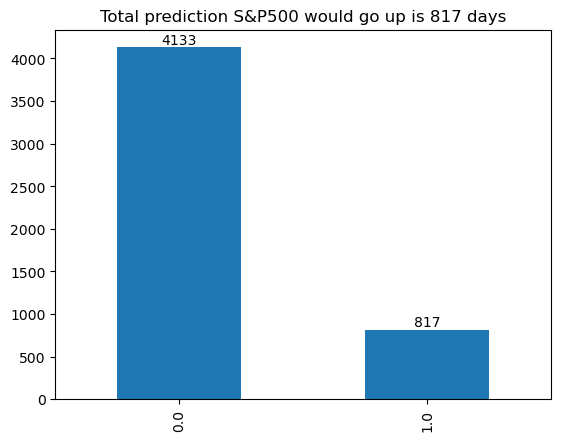

In [252]:
ax2 = predictions["Predictions"].value_counts().plot.bar(title='Total prediction S&P500 would go up is 817 days')
ax2.bar_label(ax2.containers[0])


In [253]:
precision_score_new = precision_score(predictions['Target'], predictions['Predictions'])

## 4. Conclusion

In [254]:
# compare precision score after update model features
compare = {
    "Predictors" : ['Historical absolute price', 'SMA price'],
    "Precision score": [precision_score_old, precision_score_new]
}
df = pd.DataFrame(compare)
print(df)


                  Predictors  Precision score
0  Historical absolute price         0.530183
1                  SMA price         0.569155


Now we see that with new calculated predictors and higher threshold, the precision score is improved, from 53% chance to 57% chance.
To improve this new precision_score, we need to combine with linear regression of stock price and macro economic, or stock price of specific sectors or even global market.    